# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.033055507126669714
 0.10786415823133622
 0.3578219976102398
 0.5288877856660937
 0.5338551207858526
 0.9759510193020662
 0.29183415487534836
 0.30564566956592865
 0.5971901528479301
 0.8703605316412626
 0.0647880017045771
 0.3353345074623628
 0.8658764287423419
 ⋮
 0.894401107995323
 0.20663105238322366
 0.154944091353297
 0.8364036025911935
 0.45697484726892545
 0.8029905534298131
 0.5593424622683206
 0.9464162389220125
 0.7221812832100902
 0.9759013957974633
 0.8858888625887638
 0.05942502732107757

In [2]:
sum(a)

5.000577618002433e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.003180 seconds (1 allocation: 16 bytes)


5.000577618002433e6

In [4]:
@time sum(a)

  0.003012 seconds (1 allocation: 16 bytes)


5.000577618002433e6

In [5]:
@time sum(a)

  0.003194 seconds (1 allocation: 16 bytes)


5.000577618002433e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Project.toml`
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000577618001882e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

-5.513429641723633e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 571 samples with 1 evaluation.
 Range (min … max):  8.474 ms …   9.471 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.739 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.753 ms ± 233.244 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            
  ██▅▄▂▂▂▃▃▃▂▂▁▃▃▃▂▃▄▃▃▄▂▃▃▃▃▄▄▃▂▃▂▄▃▂▂▃▂▁▂▂▂▂▂▂▁▁▂▂▁▂▁▁▂▂▂▂▁ ▂
  8.47 ms         Histogram: frequency by time        9.31 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 8.473625 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 8.47363

In [17]:
using Plots
gr()

Plots.GRBackend()

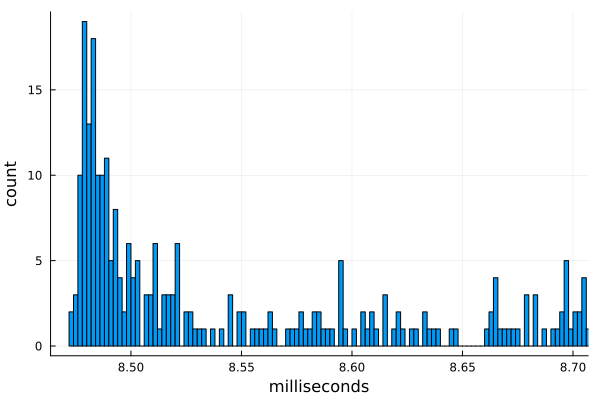

In [18]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [19]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [20]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1099 samples with 1 evaluation.
 Range (min … max):  4.401 ms …   5.475 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.487 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.545 ms ± 164.425 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▅▄▄▃▃▃▃▃▃▃▃▂▁▁▂▁▁ ▁ ▁▁                                     
  █████████████████████████▆▆▁██████▇█▇▇█▅▇▇▇▇▇▄▅▆▅▅▆▅▅▅▆▄▆▅▅ █
  4.4 ms       Histogram: log(frequency) by time      5.08 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.401398

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [22]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Project.toml`
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Manifest.toml`


In [23]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [24]:
pysum(a)

5.000577618001882e6

In [25]:
pysum(a) ≈ sum(a)

true

In [26]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 14 samples with 1 evaluation.
 Range (min … max):  372.352 ms … 376.396 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     372.939 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   373.472 ms ±   1.368 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █          ▃                                                   
  █▇▇▇▁▁▇▁▁▁▁█▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▇ ▁
  372 ms           Histogram: frequency by time          376 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [27]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 8.47363
  "Python built-in" => 372.352
  "C -ffast-math"   => 4.4014

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [28]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Project.toml`
  No Changes to `~/POTW/JULIA/Introduction-to-Julia/Manifest.toml`


In [29]:
Conda.add("numpy")

[ Info: Downloading miniconda installer ...


PREFIX=/home/simon/.julia/conda/3/x86_64


[ Info: Installing miniconda ...


Unpacking payload ...
Extracting _libgcc_mutex-0.1-conda_forge.tar.bz2
Extracting ca-certificates-2022.12.7-ha878542_0.conda
Extracting ld_impl_linux-64-2.40-h41732ed_0.conda
Extracting libstdcxx-ng-12.2.0-h46fd767_19.tar.bz2
Extracting python_abi-3.10-3_cp310.conda
Extracting tzdata-2022g-h191b570_0.conda
Extracting libgomp-12.2.0-h65d4601_19.tar.bz2
Extracting _openmp_mutex-4.5-2_gnu.tar.bz2
Extracting libgcc-ng-12.2.0-h65d4601_19.tar.bz2
Extracting bzip2-1.0.8-h7f98852_4.tar.bz2
Extracting libffi-3.4.2-h7f98852_5.tar.bz2
Extracting libnsl-2.0.0-h7f98852_0.tar.bz2
Extracting libuuid-2.32.1-h7f98852_1000.tar.bz2
Extracting libzlib-1.2.13-h166bdaf_4.tar.bz2
Extracting ncurses-6.3-h27087fc_1.tar.bz2
Extracting openssl-3.0.8-h0b41bf4_0.conda
Extracting xz-5.2.6-h166bdaf_0.tar.bz2
Extracting libsqlite-3.40.0-h753d276_0.tar.bz2
Extracting readline-8.1.2-h0f457ee_0.tar.bz2
Extracting tk-8.6.12-h27826a3_0.tar.bz2
Extracting zstd-1.5.2-h3eb15da_6.conda
Extracting python-3.10.9-he550d4f_0_cpyt

[ Info: Running `conda install -y numpy` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/simon/.julia/conda/3/x86_64

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-23.1.0               |  py310hff52083_0         918 KB  conda-forge
    libblas-3.9.0              |16_linux64_openblas          13 KB  conda-forge
    libcblas-3.9.0             |16_linux64_openblas          13 KB  conda-forge
    libgfortran-ng-12.2.0      |      h69a702a_19          22 KB  conda-forge
    libgfortran5-12.2.0        |      h337968e_19         1.8 MB  conda-forge
    liblapack-3.9.0            |16_linux64_openblas          13 KB  conda-forge
    libopenblas-0.3.21         |pthreads_h78a6416_3        10.1 MB  conda-forge
    numpy-1.24.2               |  py310h8deb116_0         6.4 MB  conda-forge
    ----------------------

In [30]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1523 samples with 1 evaluation.
 Range (min … max):  3.093 ms …   4.641 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.212 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.275 ms ± 189.829 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▆██▇▇▅▂▂▁                                                   
  ▅█████████▇▇▇▆▄▅▅▃▃▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  3.09 ms         Histogram: frequency by time           4 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [31]:
numpy_sum(a)

5.000577618002426e6

In [32]:
numpy_sum(a) ≈ sum(a)

true

In [33]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 8.47363
  "Python numpy"    => 3.09314
  "Python built-in" => 372.352
  "C -ffast-math"   => 4.4014

# 5. Python, hand-written 

In [34]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fa5e8cd3670>

In [35]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  452.021 ms … 459.867 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     454.920 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   455.599 ms ±   2.508 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █         █   █   ██  █ █       █          █               ██  
  █▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁██▁▁█▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██ ▁
  452 ms           Histogram: frequency by time          460 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [36]:
sum_py(a)

5.000577618001882e6

In [37]:
sum_py(a) ≈ sum(a)

true

In [38]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 8.47363
  "Python numpy"        => 3.09314
  "Python hand-written" => 452.021
  "Python built-in"     => 372.352
  "C -ffast-math"       => 4.4014

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [39]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [40]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1628 samples with 1 evaluation.
 Range (min … max):  2.820 ms …   4.924 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.958 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.065 ms ± 282.915 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▄▃▆█▇▅▃▃▃▃▂▂▂▁▁▁ ▁ ▂ ▂▁                                    ▁
  █████████████████▇███████▇█▇▇▆▅▆▁▅▄▄▅▄▁▅▁▅▅▄▅▅▆▁▅▆▅▆▄▆▁▄▄▄▄ █
  2.82 ms      Histogram: log(frequency) by time      4.39 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [41]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 8.47363
  "Python numpy"        => 3.09314
  "Python hand-written" => 452.021
  "Python built-in"     => 372.352
  "Julia built-in"      => 2.81955
  "C -ffast-math"       => 4.4014

# 7. Julia (hand-written) 

In [42]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [43]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 586 samples with 1 evaluation.
 Range (min … max):  8.475 ms …   9.961 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.497 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.538 ms ± 124.508 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇█▅▄▂▂▁▁ ▁▁  ▁                                               
  ████████████▇█▇▅▇▅▅▅▄▄▁▄▄▅▄▁▁▄▁▅▁▄▁▁▄▄▁▁▁▁▁▁▁▁▄▁▁▄▄▁▁▁▁▁▁▁▄ ▇
  8.48 ms      Histogram: log(frequency) by time      9.19 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 8.47363
  "Python numpy"        => 3.09314
  "Julia hand-written"  => 8.47517
  "Python hand-written" => 452.021
  "Python built-in"     => 372.352
  "Julia built-in"      => 2.81955
  "C -ffast-math"       => 4.4014

# 8. Julia (hand-written w. simd) 

In [45]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [46]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1678 samples with 1 evaluation.
 Range (min … max):  2.777 ms …   4.641 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.863 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.972 ms ± 275.592 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇███▇▆▅▄▃▃▂▂▁▂▁ ▁          ▁                                ▁
  ██████████████████▇█▇▇▇▅▅█▅██▄▇▇▅█▆█▆▄█▅▅▆▅▄▇▅▆▆▆▃▆▅▃▅▅▃▅▆▃ █
  2.78 ms      Histogram: log(frequency) by time      3.99 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
mysum_simd(a)

5.000577618002452e6

In [48]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 2.77686
  "C"                       => 8.47363
  "Python numpy"            => 3.09314
  "Julia hand-written"      => 8.47517
  "Python hand-written"     => 452.021
  "Python built-in"         => 372.352
  "Julia built-in"          => 2.81955
  "C -ffast-math"           => 4.4014

# Summary

In [49]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....2.8
Julia built-in..............2.8
Python numpy................3.1
C -ffast-math...............4.4
C...........................8.5
Julia hand-written..........8.5
Python built-in...........372.4
Python hand-written.......452.0
